## Import packages

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer,f1_score, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

## Load Dataset

In [155]:
data1 = pd.read_csv('merge_stock_news_amazon.csv')
data2 = pd.read_csv('merge_stock_news_tesla.csv')
data1.loc[:,'ticker'] = 'amazon'
data2.loc[:,'ticker'] = 'tesla'
data = data1.append(data2)
#change the type of Date to Datetime
data['Date'] =pd.to_datetime(data.Date)
data = data.sort_values('Date')
data.head()

,Date,Weekday,Yesterday_pos,Yesterday_neg,Yesterday_neu,Positive,Negative,Neutral,Yesterday_price_change,Price_change,Yesterday_open,Yesterday_close,Yesterday_volume,Yesterday_high,Yesterday_low,Yesterday_Adj_close,ticker
0,2017-01-04,Wednesday,0.119593,0.042743,0.837664,0.416015,0.054345,0.529640,NaN,1.0,37.896000,37.683498,70422000,37.938000,37.384998,37.683498,amazon
0,2017-01-04,Wednesday,0.550024,0.351256,0.098720,0.394854,0.198030,0.407116,NaN,1.0,42.972000,43.397999,29616500,44.066002,42.192001,43.397999,tesla
1,2017-01-05,Thursday,0.394854,0.198030,0.407116,0.353168,0.051893,0.594939,1.0,0.0,42.950001,45.397999,56067500,45.599998,42.862000,45.397999,tesla
1,2017-01-05,Thursday,0.416015,0.054345,0.529640,0.128640,0.036761,0.834599,1.0,1.0,37.919498,37.859001,50210000,37.984001,37.709999,37.859001,amazon
2,2017-01-06,Friday,0.128640,0.036761,0.834599,0.222731,0.061406,0.715863,1.0,1.0,38.077499,39.022499,116602000,39.119999,38.013000,39.022499,amazon


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314 entries, 0 to 1153
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2314 non-null   datetime64[ns]
 1   Weekday                 2314 non-null   object        
 2   Yesterday_pos           2314 non-null   float64       
 3   Yesterday_neg           2314 non-null   float64       
 4   Yesterday_neu           2314 non-null   float64       
 5   Positive                2017 non-null   float64       
 6   Negative                2017 non-null   float64       
 7   Neutral                 2017 non-null   float64       
 8   Yesterday_price_change  1804 non-null   float64       
 9   Price_change            1820 non-null   float64       
 10  Yesterday_open          2314 non-null   float64       
 11  Yesterday_close         2314 non-null   float64       
 12  Yesterday_volume        2314 non-null   int64   

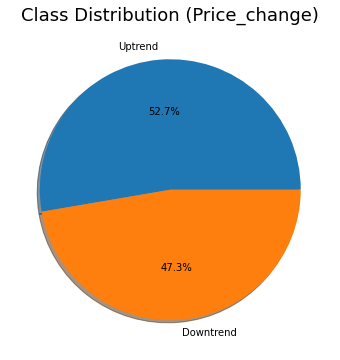

,Yesterday_pos,Yesterday_neg,Yesterday_neu,Positive,Negative,Neutral,Yesterday_price_change,Price_change,Yesterday_open,Yesterday_close,Yesterday_volume,Yesterday_high,Yesterday_low,Yesterday_Adj_close
count,2314.000000,2314.000000,2314.000000,2017.000000,2017.000000,2017.000000,1804.000000,1820.000000,2314.000000,2314.000000,2.314000e+03,2314.000000,2314.000000,2314.000000
mean,0.263232,0.170101,0.566667,0.256946,0.163308,0.579746,0.529933,0.526923,184.765922,184.881556,6.556393e+07,188.203057,181.121400,184.881556
std,0.142614,0.135875,0.169574,0.140752,0.139637,0.170034,0.499242,0.499412,231.839385,232.059054,4.189189e+07,237.046786,226.266364,232.059054
min,0.013175,0.007845,0.034318,0.013175,0.007845,0.034318,0.000000,0.000000,36.220001,35.793999,9.800600e+06,37.335999,35.397999,35.793999
25%,0.158246,0.057743,0.458178,0.152040,0.047222,0.471699,0.000000,0.000000,62.273125,62.251000,3.514312e+07,63.262499,61.099998,62.251000
50%,0.244488,0.145386,0.573218,0.238767,0.132879,0.584196,1.000000,1.000000,88.411499,88.327751,5.664000e+07,89.311497,87.347752,88.327751
75%,0.349994,0.245789,0.681518,0.342105,0.236843,0.700102,1.000000,1.000000,164.995880,164.699623,8.475700e+07,166.553123,163.034630,164.699623
max,0.925848,0.936819,0.938232,0.925848,0.936819,0.938232,1.000000,1.000000,1234.410034,1229.910034,3.313000e+08,1243.489990,1217.000000,1229.910034


In [157]:
#target variable is "Price_change"
uptrend = len(data[data['Price_change']==1])
downtrend = len(data[data['Price_change']==0])

fig, ax = plt.subplots(figsize=(6,6))
plt.pie(x=[uptrend, downtrend], labels=['Uptrend','Downtrend'], shadow=True, autopct='%1.1f%%')
plt.title('Class Distribution (Price_change)', fontsize=18)
plt.show()
data.describe()

## Drop/add features

In [158]:
#select features
cols = ['Date','ticker','Weekday','Price_change','Positive', \
        'Negative', 'Neutral','Yesterday_pos','Yesterday_neg','Yesterday_neu']
df = data[cols]
df = df.dropna()

In [159]:
# one-hot encoding 
one_hot_encoding_columns = ['ticker','Weekday']

# encode categorical variables with more than two levels using one-hot encoding
df_transformed = pd.get_dummies(df, columns = one_hot_encoding_columns)
df_transformed

,Date,Price_change,Positive,Negative,Neutral,Yesterday_pos,Yesterday_neg,Yesterday_neu,ticker_amazon,ticker_tesla,Weekday_Friday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2017-01-04,1.0,0.416015,0.054345,0.529640,0.119593,0.042743,0.837664,1,0,0,0,0,1
0,2017-01-04,1.0,0.394854,0.198030,0.407116,0.550024,0.351256,0.098720,0,1,0,0,0,1
1,2017-01-05,0.0,0.353168,0.051893,0.594939,0.394854,0.198030,0.407116,0,1,0,1,0,0
1,2017-01-05,1.0,0.128640,0.036761,0.834599,0.416015,0.054345,0.529640,1,0,0,1,0,0
2,2017-01-06,1.0,0.222731,0.061406,0.715863,0.128640,0.036761,0.834599,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,2021-12-29,0.0,0.225209,0.232646,0.542145,0.270271,0.078007,0.651721,1,0,0,0,0,1
1157,2021-12-30,0.0,0.134685,0.163041,0.702274,0.225209,0.232646,0.542145,1,0,0,1,0,0
1151,2021-12-30,0.0,0.068232,0.659719,0.272049,0.208069,0.167552,0.624379,0,1,0,1,0,0
1158,2021-12-31,0.0,0.244497,0.179205,0.576298,0.134685,0.163041,0.702274,1,0,1,0,0,0


In [160]:
# Input features and labels
X = np.array(df_transformed[['Positive', 'Negative', 'Neutral','ticker_amazon', 'ticker_tesla',\
                            'Yesterday_pos','Yesterday_neg','Yesterday_neu','Weekday_Thursday',\
                            'Weekday_Wednesday','Weekday_Friday','Weekday_Tuesday']])
y = np.array(df_transformed['Price_change'])

# train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state=24)
#sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


## Evaluation metrics for cross validation

In [161]:
#Evaluation metrics
scoring = {'accuracy' : make_scorer(accuracy_score, greater_is_better=True), 
           'f1_macro' : make_scorer(f1_score, average='macro', greater_is_better=True),
           'precision' : make_scorer(precision_score, zero_division=0),
           'recall' : make_scorer(recall_score, average='macro')  }

## Logistic Regression

In [162]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.548506 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


10-fold cross validation metrics:
Mean accs :  0.5485055923390566
Mean f1_macro 0.5115201836005139
Mean precision 0.5535162885826844
Mean recall 0.5338160384048616
------------------------------------------------------------------------------------------


Testing results:


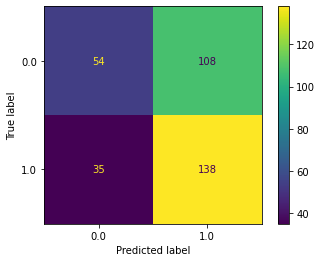

              precision    recall  f1-score   support

         0.0       0.61      0.33      0.43       162
         1.0       0.56      0.80      0.66       173

    accuracy                           0.57       335
   macro avg       0.58      0.57      0.54       335
weighted avg       0.58      0.57      0.55       335



In [163]:
log_reg = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
log_reg.fit(X_train, y_train)
# 10- fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(log_reg, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print('10-fold cross validation metrics:')
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
print("---------"*10)
print("\n")
print("Testing results:")
predictions = log_reg.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=log_reg.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, log_reg.predict(X_test)))

## Naive Bayes

In [164]:
#Define Grid Search Parameters
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
#print(nbModel_grid.best_estimator_)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best: 0.548506 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


10-fold cross validation metrics:
Mean accs :  0.5482811506377885
Mean f1_macro 0.5383502173119827
Mean precision 0.5643390449503765
Mean recall 0.5418048313777527
------------------------------------------------------------------------------------------


Testing results:


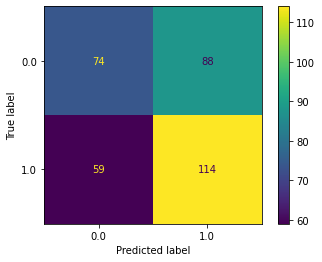

              precision    recall  f1-score   support

         0.0       0.56      0.46      0.50       162
         1.0       0.56      0.66      0.61       173

    accuracy                           0.56       335
   macro avg       0.56      0.56      0.55       335
weighted avg       0.56      0.56      0.56       335



In [165]:
nb = GaussianNB(var_smoothing=0.23101297000831597)
nb.fit(X_train, y_train)

print('10-fold cross validation metrics:')
# 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(nb, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
print("---------"*10)
print("\n")
print("Testing results:")
predictions = nb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=nb.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, nb.predict(X_test)))

## SVM with hyperparameter tuning

In [166]:
# use grid_search to get the best hyperparameter sets
model = svm.SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.562900 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.541742 (0.034730) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.562900 (0.041876) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.511063 (0.043376) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.545979 (0.038199) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.560913 (0.037592) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.507618 (0.037956) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543996 (0.037675) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.548466 (0.040632) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.483468 (0.040584) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.551216 (0.037445) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.541011 (0.020898) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.517877 (0.031233) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.529295 (0.010415) with: {'C': 0.01, 'gamma': 'scale', 

10-fold cross validation metrics:
Mean accs :  0.562899786780384
Mean f1_macro 0.5487031404997597
Mean precision 0.573630397054602
Mean recall 0.5543214484036838


Testing results:


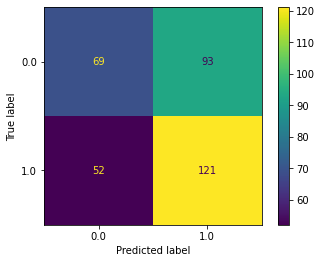

              precision    recall  f1-score   support

         0.0       0.57      0.43      0.49       162
         1.0       0.57      0.70      0.63       173

    accuracy                           0.57       335
   macro avg       0.57      0.56      0.56       335
weighted avg       0.57      0.57      0.56       335



In [167]:
model = svm.SVC(kernel='rbf', C=50, gamma='scale')
model.fit(X_train, y_train)

# 10 fold cross validation
print('10-fold cross validation metrics:')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
 
print("\n")
print("Testing results:")
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, model.predict(X_test)))

## Random Forest

In [170]:
model = RandomForestClassifier(random_state = 3)
n_estimators = [10, 100, 200, 1000]
max_features = [1, 2, 3, 4, 5, 6]
criterions = ['gini', 'entropy', 'log_loss']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features, criterion=criterions)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/nankli/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
  

Best: 0.512555 using {'criterion': 'gini', 'max_features': 1, 'n_estimators': 100}


10-fold cross validation metrics:
Mean accs :  0.5207889125799573
Mean f1_macro 0.5150141406571052
Mean precision 0.5453273906460938
Mean recall 0.5164686446035833


Testing results:


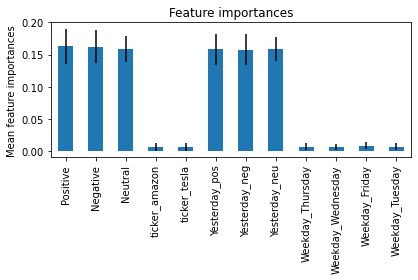

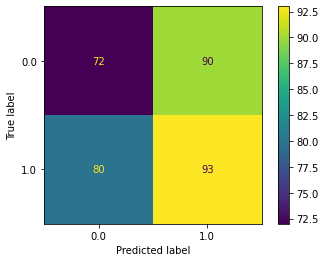

              precision    recall  f1-score   support

         0.0       0.47      0.44      0.46       162
         1.0       0.51      0.54      0.52       173

    accuracy                           0.49       335
   macro avg       0.49      0.49      0.49       335
weighted avg       0.49      0.49      0.49       335



In [169]:
model = RandomForestClassifier(n_estimators =100 , max_features=1,criterion='', random_state=3)
model.fit(X_train, y_train)
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=['Positive', 'Negative', 'Neutral','ticker_amazon', 'ticker_tesla',\
                            'Yesterday_pos','Yesterday_neg','Yesterday_neu','Weekday_Thursday',\
                            'Weekday_Wednesday','Weekday_Friday','Weekday_Tuesday'])

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean feature importances")
fig.tight_layout()


# 10 fold cross validation
print('10-fold cross validation metrics:')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
 
print("\n")
print("Testing results:")
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, model.predict(X_test)))